In [135]:
import sys

from skimage.metrics import structural_similarity as ssim

from skimage.util import view_as_blocks

import numpy as np

from skimage.metrics import peak_signal_noise_ratio

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import backend as K

from sklearn.model_selection import train_test_split

from data_importer import load_testing_images
from data_importer import load_training_images, denormalize, trunc

import matplotlib.pyplot as plt

In [136]:

# Common testing image pairs (used to evaluate all models)

noisy_images, ground_truth_images = load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', load_limited_images=True, num_images_to_load=10)

_n, _g = load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Selected_Image_Pairs/', load_limited_images=False)
noisy_images = np.concatenate((noisy_images, _n), axis=0)
ground_truth_images = np.concatenate((ground_truth_images, _g), axis=0)

noisy_images = np.squeeze(noisy_images, axis=-1)
ground_truth_images = np.squeeze(ground_truth_images, axis=-1)

loaded training images x and y of len :  10 10  respectively
type of train images x :  float64
range of values in train images :  0.0 0.576171875
type of train images y :  float64
loaded training images x and y of len :  5 5  respectively
type of train images x :  float64
range of values in train images :  0.0 0.915283203125
type of train images y :  float64


In [137]:
print(noisy_images.shape)
print(ground_truth_images.shape)

(15, 512, 512)
(15, 512, 512)


Visualization of noisy / ground truth image pair

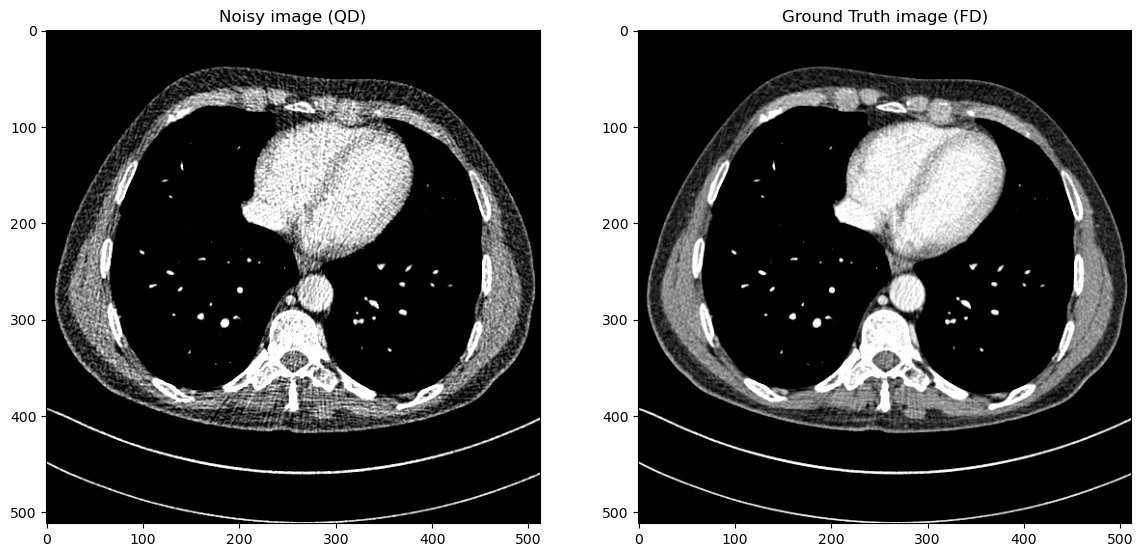

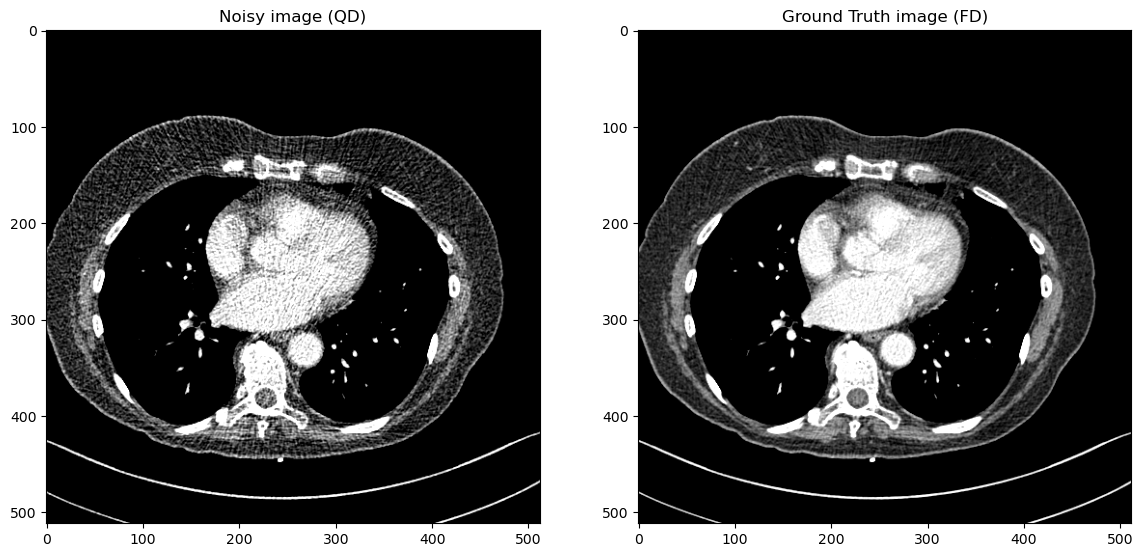

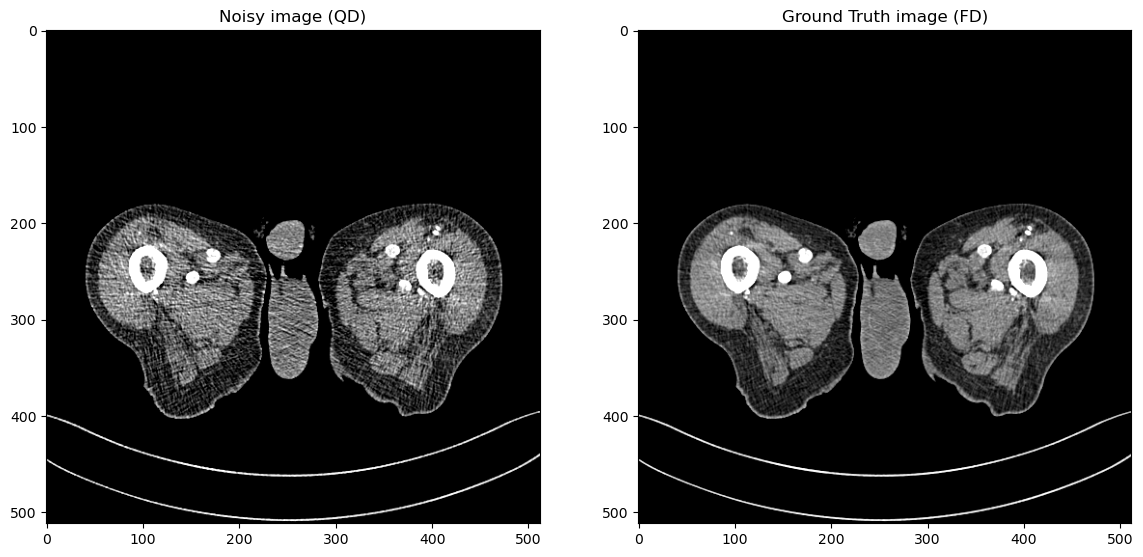

In [138]:
from data_importer import denormalize, trunc

for i in range(6, 15, 4):
    f, axarr = plt.subplots(1,2, figsize=(14,14))
    axarr[0].imshow(trunc(denormalize(noisy_images[i])), vmin=-160.0, vmax=240.0, cmap='gray')
    axarr[0].set_title("Noisy image (QD)")
    axarr[1].imshow(trunc(denormalize(ground_truth_images[i])), vmin=-160.0, vmax=240.0, cmap='gray')
    axarr[1].title.set_text("Ground Truth image (FD)")
    plt.show()

In [139]:
print(noisy_images.shape)

(15, 512, 512)


In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image

def display_and_get_all_wavelet_coeffs(image):

    coeffs2 = pywt.dwt2(image, 'haar')
    
    LL, (LH, HL, HH) = coeffs2
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Display the original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display the wavelet bands
    titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
    for i, a in enumerate([LL, LH, HL, HH]):
        axes[i+1].imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        axes[i+1].set_title(titles[i])
        axes[i+1].axis('off')

    plt.show()
    
    return LL, (LH, HL, HH)
    
    

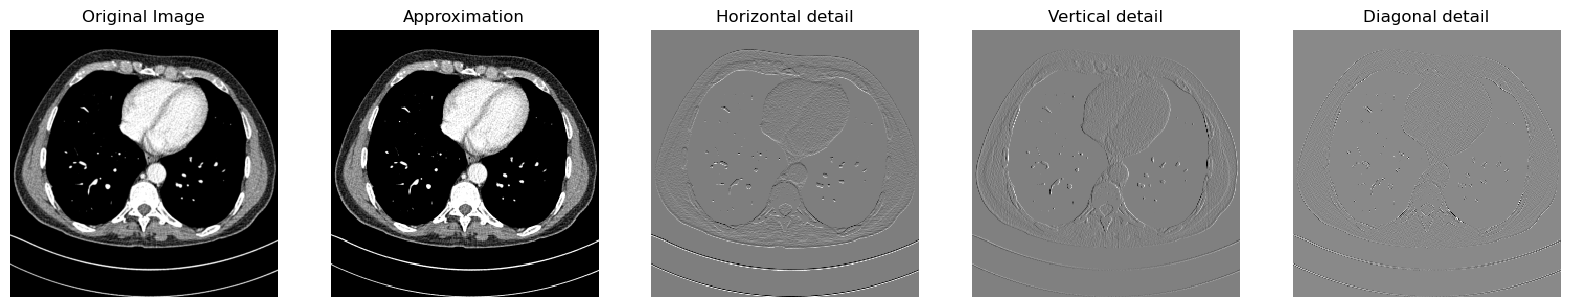

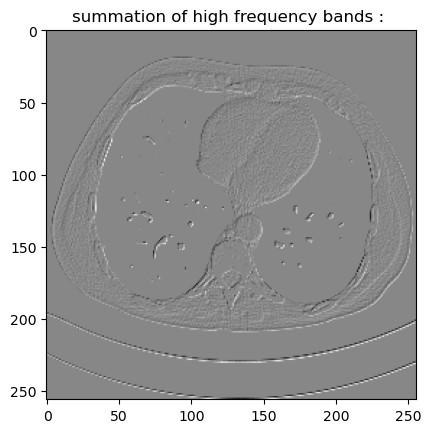

In [141]:
LL, detail_coeffs = display_and_get_all_wavelet_coeffs(trunc(denormalize(ground_truth_images[0])))

plt.title('summation of high frequency bands : ')
plt.imshow(detail_coeffs[0] + detail_coeffs[1] + detail_coeffs[2], cmap='gray')
plt.show()

noisy image


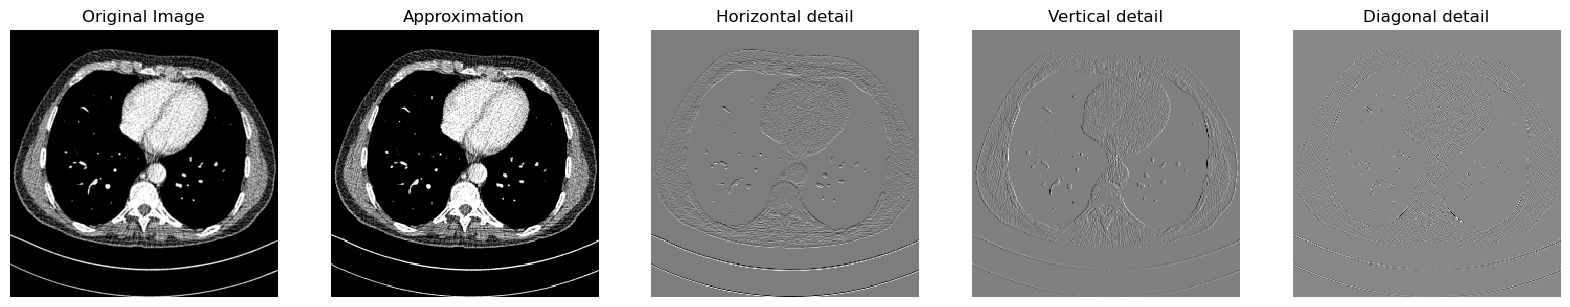

ground truth image


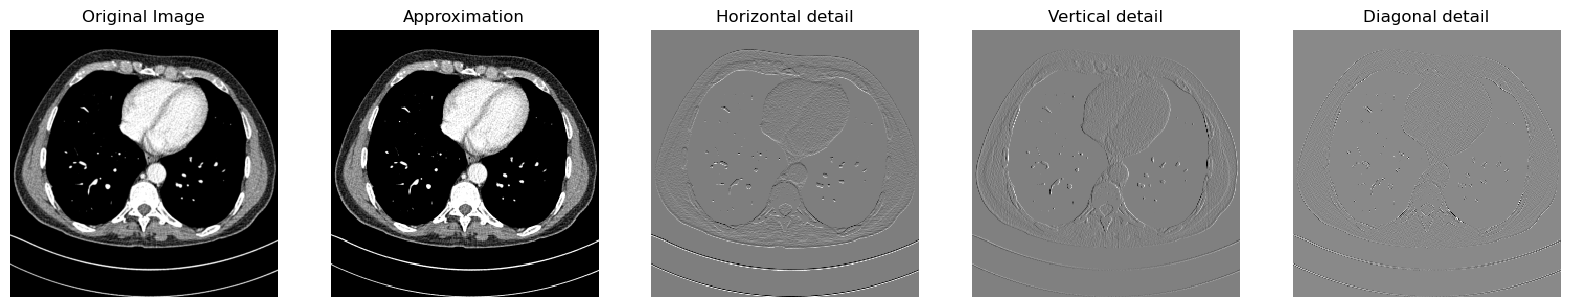

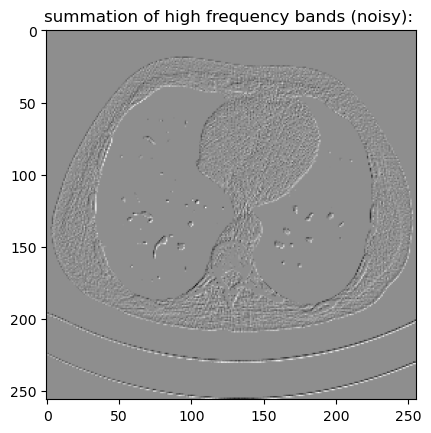

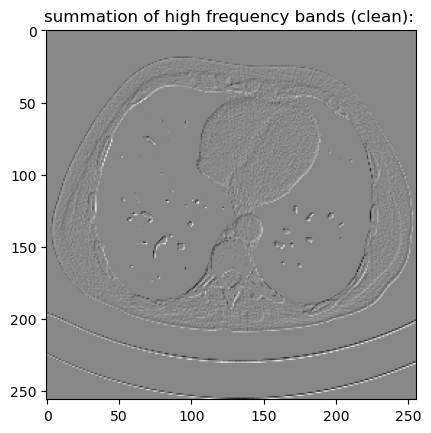

In [142]:
print('noisy image')
LL_noisy, detail_coeffs_noisy = display_and_get_all_wavelet_coeffs(trunc(denormalize(noisy_images[0])))

print('ground truth image')
LL_clean, detail_coeffs_clean = display_and_get_all_wavelet_coeffs(trunc(denormalize(ground_truth_images[0])))


plt.title('summation of high frequency bands (noisy): ')
plt.imshow(detail_coeffs_noisy[0] + detail_coeffs_noisy[1] + detail_coeffs_noisy[2], cmap='gray')
plt.show()

plt.title('summation of high frequency bands (clean): ')
plt.imshow(detail_coeffs_clean[0] + detail_coeffs_clean[1] + detail_coeffs_clean[2], cmap='gray')
plt.show()

Comparison of high frequency band in clean and noisy image

In [143]:
def reconstruct_image_from_coeffs(LL, detail_coeffs):
    idwt = pywt.idwt2((LL, detail_coeffs), 'haar')
    plt.imshow(idwt, cmap='gray')
    
    return idwt

(512, 512)


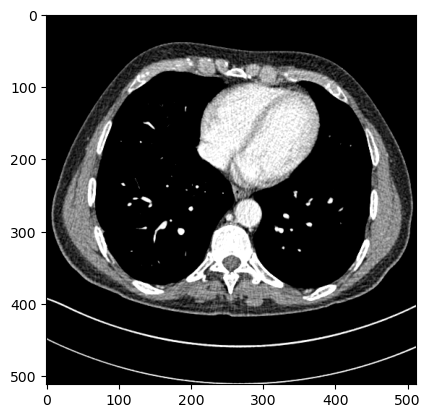

In [144]:
recon_image = reconstruct_image_from_coeffs(LL, detail_coeffs)
print(recon_image.shape)

Has any information been lost by performing IDWT?

In [145]:
from skimage.metrics import structural_similarity
print(ground_truth_images[0].shape, recon_image.shape)
ssim = structural_similarity(trunc(denormalize(ground_truth_images[0])), recon_image, data_range=1)

print('The SSIM value between reconstructed image and source image (to the DWT) is : ', ssim)

(512, 512) (512, 512)
The SSIM value between reconstructed image and source image (to the DWT) is :  0.9999999948499222


What is the visual effect of performing denoising via HFORMER on the DWT coeffs?

In [150]:
sys.path.append('../denoising-models/hformer_vit/model/')
sys.path.append('../denoising-models/hformer_vit/')
from hformer_model_extended import get_hformer_model

hformer_model = get_hformer_model(num_channels_to_be_generated=64, name="hformer")
hformer_model.build(input_shape=(None, 512, 512, 1))
hformer_model.load_weights('../denoising-models/hformer_vit/test/experiments/full_dataset/hformer_64_channel_custom_loss_epochs_48.h5')
print('Model summary : ')
print(hformer_model.summary())

Model summary : 
Model: "hformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_projection_layer (Inp  multiple                 320       
 utProjectionLayer)                                              
                                                                 
 output_projection_layer (Ou  multiple                 257       
 tputProjectionLayer)                                            
                                                                 
 conv_net_block_1 (Convoluti  multiple                 36416     
 onBlock)                                                        
                                                                 
 conv_net_block_2 (Convoluti  multiple                 36416     
 onBlock)                                                        
                                                                 
 downsampling_layer_1 (Conv2  multiple    

In [155]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))
    # Reconstruct the image by placing each patch in its corresponding position

    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)

from hformer_model_extended import PatchExtractor
pe = PatchExtractor(patch_size=64, stride=64, name="patch_extractor")



In [158]:
# View the predictions
noisy_image_patches_array = pe(np.expand_dims(noisy_images, axis=-1))

hformer_prediction_patches = hformer_model.predict(noisy_image_patches_array)

30/30 [==============================] - 51s 831ms/step


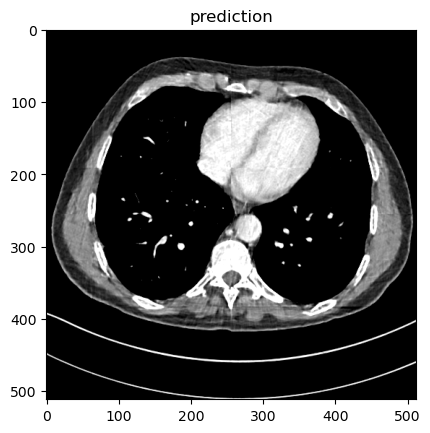

dwt on prediction


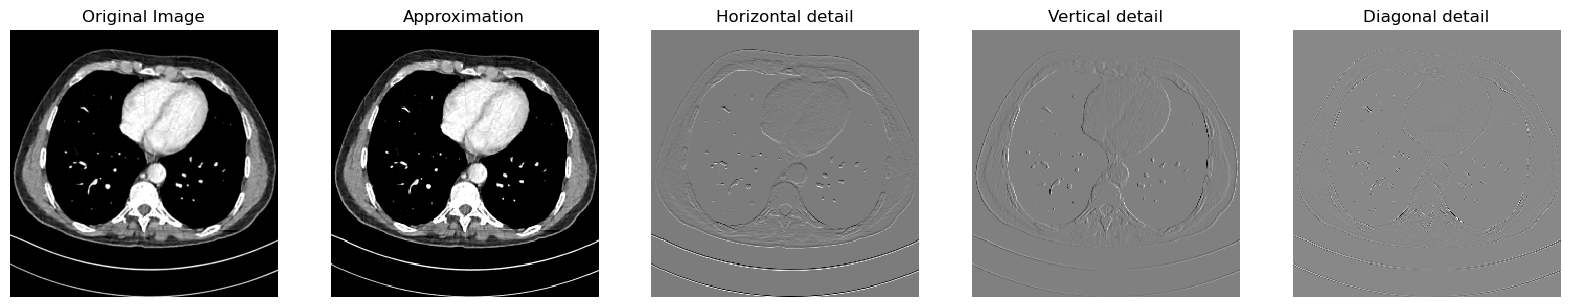

clean image coeffs


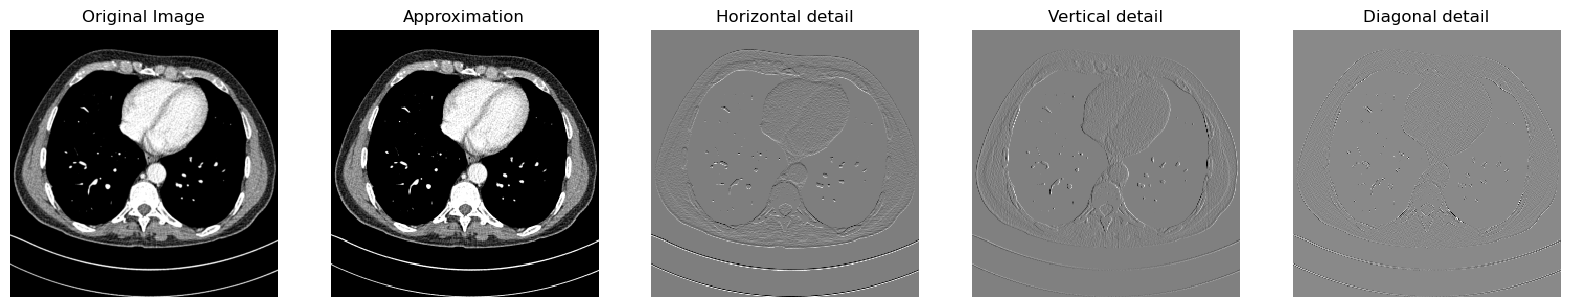

In [172]:
hformer_predictions = np.expand_dims(reconstruct_image_from_patches(hformer_prediction_patches[0:64], 8), axis=0)

plt.title('prediction')
plt.imshow(trunc(denormalize(hformer_predictions[0])), cmap='gray')
plt.show()

print('dwt on prediction')
pred_dwt_coeffs = display_and_get_all_wavelet_coeffs(trunc(denormalize(np.squeeze(hformer_predictions[0], axis=-1))))
print('clean image coeffs')
clean_image_coeffs = display_and_get_all_wavelet_coeffs(trunc(denormalize(ground_truth_images[0])))


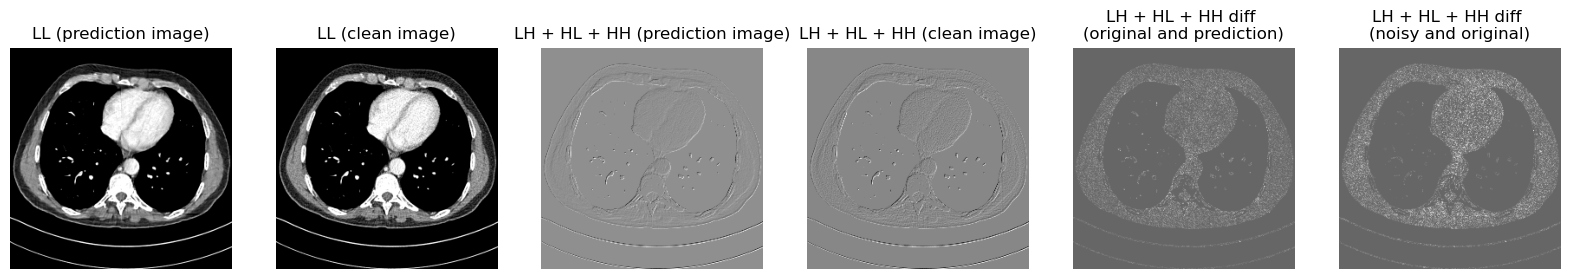

In [188]:
# How did the existing hformer model perform on low freq regions vs high freq?
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

axes[0].set_title('LL (prediction image)')
axes[0].imshow(pred_dwt_coeffs[0], cmap='gray')
axes[0].axis('off')

axes[1].set_title('LL (clean image)')
axes[1].imshow(clean_image_coeffs[0], cmap='gray')
axes[1].axis('off')

axes[2].set_title('LH + HL + HH (prediction image)')
axes[2].imshow(pred_dwt_coeffs[1][0] + pred_dwt_coeffs[1][1] + pred_dwt_coeffs[1][2], cmap='gray')
axes[2].axis('off')

axes[3].set_title('LH + HL + HH (clean image)')
axes[3].imshow(clean_image_coeffs[1][0] + clean_image_coeffs[1][1] + clean_image_coeffs[1][2], cmap='gray')
axes[3].axis('off')

axes[4].set_title('LH + HL + HH diff \n(original and prediction)')
axes[4].imshow(np.abs(pred_dwt_coeffs[1][0] + pred_dwt_coeffs[1][1] + pred_dwt_coeffs[1][2] -  (clean_image_coeffs[1][0] + clean_image_coeffs[1][1] + clean_image_coeffs[1][2])), cmap='gray', vmin=-160.0, vmax=240.0)
axes[4].axis('off')

axes[5].set_title('LH + HL + HH diff \n(noisy and original)')
axes[5].imshow(np.abs(pred_dwt_coeffs[1][0] + pred_dwt_coeffs[1][1] + pred_dwt_coeffs[1][2] -  (detail_coeffs_noisy[0] + detail_coeffs_noisy[1] + detail_coeffs_noisy[2])), cmap='gray', vmin=-160.0, vmax=240.0)
axes[5].axis('off')
plt.show()